In [41]:
import os
import tensorflow
import tensorflow.keras
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, ReLU, Input, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential, Model

import numpy as np

LOAD DATABASES, CONCATENATE AND MIX THEM

In [146]:
rv = [54.]
nr = len(rv)



def load_and_shuffle_dbs(rv):
    paths = []
    for r in rv:
        paths.append(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")
    
    n_traj = 50000
    db = np.ndarray(shape=(nr*n_traj,2000,1))
    labels = []
    for path,r,i in zip(paths,rv,range(nr)):
        db1 = np.load(path)
        for j in range(n_traj):
            db[i*n_traj + j,:,0] = db1[j,0,:]
            labels.append(r)
    
    labels = np.array(labels)
    
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]
    
    db, labels = unison_shuffled_copies(db, labels)
    return db, labels




db, labels = load_and_shuffle_dbs(rv)

PREPROCESSING

In [147]:
validation_split = 0.0

sig_len = len(db[0,:,0])
print(f"siglen: {sig_len}")
channels = 1 #len(db[0,0,:])
print(f"channels: {channels}")
n_traj = len(db[:,0,0])
print((f"n_traj: {n_traj}"))
# numero della prima traiettoria usata come validation
first_validation = n_traj #   round((1. - validation_split)*n_traj)
#  print(f"first_validation: {first_validation}")
db_train = np.ndarray(shape=(first_validation,sig_len,channels))
#db_test = np.ndarray(shape=(n_traj-first_validation,sig_len,channels))
db_train = db[:first_validation,:,0:channels]
#db_test = db[first_validation:,:,0:channels]
del db

print(db_train.shape)
#M = np.max(np.append(db_train, db_test))
#m = np.min(np.append(db_train, db_test))
M = np.max(db_train)
m = np.min(db_train)
print(M,m)
db_train = (db_train - m)/(M - m)
#db_test = (db_test - m)/(M - m)
M = np.max(db_train)
m = np.min(db_train)
print(M,m)

siglen: 2000
channels: 1
n_traj: 50000
(50000, 2000, 1)
31.27666666957781 -31.28223237314301
1.0 0.0


VISUALIZE DATA

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
%matplotlib inline

def plot_trajs(noise, real_trajs=None, epoch=None):
    import matplotlib.pyplot as plt
    gen_trajs = gen.predict(noise)
    
    try:
        if real_trajs==None:
            plt.figure(figsize=(18, 2))
            for i, traj in enumerate(gen_trajs):
                plt.subplot(1, 1, i+1)
                plt.plot(traj)
                plt.axis('off')
    except:
        plt.figure(figsize=(18, 4))
        for i, traj in enumerate(gen_trajs):
            plt.subplot(2, 1, i+1)
            plt.plot(traj)
            #plt.axis('off')
        for i in range(len(gen_trajs)):
            plt.subplot(2, 1, len(gen_trajs)+i+1)
            n = round(np.random.uniform(0,len(real_trajs[:,0,0])))
            plt.plot(real_trajs[n,:,:])
            #plt.axis('off')
    plt.tight_layout()
    plt.show()

ARCHITETTURA RETE NEURALE

# Generatore

In [105]:
class Conv1DTranspose(tensorflow.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='valid', kernel_initializer=RandomNormal(0, 0.02)):
        super().__init__()
        self.conv2dtranspose = tensorflow.keras.layers.Conv2DTranspose(
          filters, (kernel_size, 1), (strides, 1), padding, kernel_initializer=RandomNormal(0, 0.02)
        )

    def call(self, x):
        x = tensorflow.expand_dims(x, axis=2)
        x = self.conv2dtranspose(x)
        x = tensorflow.squeeze(x, axis=2)
        return x

noise_dim = 100
optimizer = Adam(0.00008)
sig_len, channels = len(db_train[0,:,0]), len(db_train[0,0,:])
fs = 20 # dimensione filtro
fm = 8 # numero filtri
init_sigma = 0.02 # varianza distribuzione parametri iniziali dei kernel

def create_gen():
    generator = Sequential()
    #100x1
    d = 10
    generator.add(Dense(d*8, activation='relu', kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    #80x1
    generator.add(Reshape((d, fm)))
    #10x8
    generator.add(Conv1DTranspose(4, fs, strides=5, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    #50x4
    generator.add(Conv1DTranspose(2, fs, strides=5, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    #250x2
    generator.add(Conv1DTranspose(1, fs, strides=8, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    #2000x1
    
    generator.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return generator

gen = create_gen()

#gen.summary()

# Discriminatore

In [149]:
opt = Adam(0.00008)
sig_len, channels = len(db_train[0,:,0]), len(db_train[0,0,:])
fs = 20 # dimensione filtro
fm = 8 # numero filtri
sigma_init = 0.1 # varianza distribuzione parametri iniziali dei kernel
mean_init = 0.0
def create_disc():
    discriminator = Sequential()
    #2000x1
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init), input_shape=(sig_len, channels)))    
    #250x8
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init)))    
    #32x8
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init))) 
    #8x8
    discriminator.add(Flatten())
    #64x1
    discriminator.add(Dense(8*fm, activation='relu'))
    #64x1
    discriminator.add(Dense(1, activation='sigmoid'))
    #1x1
    
    discriminator.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer=opt)
    return discriminator

disc = create_disc()

#disc.summary()

# Gan

In [150]:
# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
disc.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))
fake_traj = gen(gan_input)

gan_output = disc(fake_traj)

gan = Model(gan_input, gan_output)
optimizer = Adam(0.0008)
gan.compile(loss='binary_crossentropy', optimizer=opt)

# Training

W0419 13:03:42.728461 47325737348608 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Epoch: 0 	 Discriminator Loss: [0.005072965, 0.998] 		 Generator Loss: 15.533454895019531


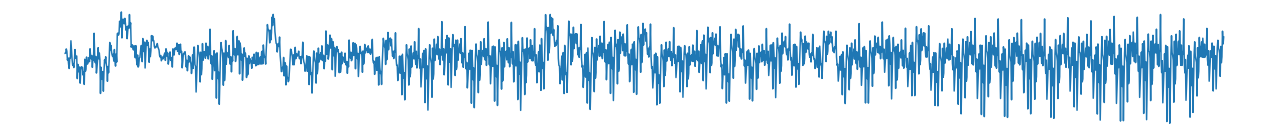

Epoch: 1 	 Discriminator Loss: [0.015978249, 0.994] 		 Generator Loss: 10.641804695129395
Epoch: 2 	 Discriminator Loss: [0.020701556, 0.994] 		 Generator Loss: 9.969736099243164
Epoch: 3 	 Discriminator Loss: [0.015143487, 0.994] 		 Generator Loss: 10.87398910522461
Epoch: 4 	 Discriminator Loss: [0.01395546, 0.996] 		 Generator Loss: 10.829108238220215
Epoch: 5 	 Discriminator Loss: [0.02802789, 0.99] 		 Generator Loss: 9.482446670532227
Epoch: 6 	 Discriminator Loss: [0.018553905, 0.996] 		 Generator Loss: 7.687219142913818
Epoch: 7 	 Discriminator Loss: [0.015692927, 0.994] 		 Generator Loss: 7.937946796417236
Epoch: 8 	 Discriminator Loss: [0.016011124, 0.998] 		 Generator Loss: 8.037101745605469
Epoch: 9 	 Discriminator Loss: [0.0071279225, 1.0] 		 Generator Loss: 9.282355308532715
Epoch: 10 	 Discriminator Loss: [0.0034553418, 1.0] 		 Generator Loss: 8.737910270690918
Epoch: 11 	 Discriminator Loss: [0.0051509235, 0.998] 		 Generator Loss: 8.909612655639648
Epoch: 12 	 Discrimin

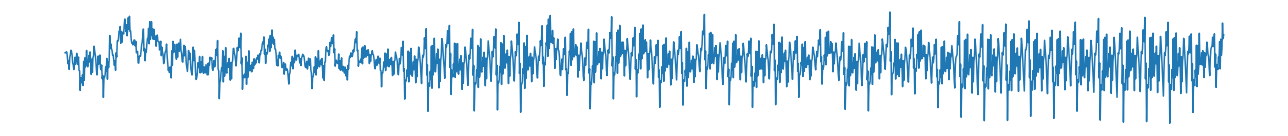

Epoch: 16 	 Discriminator Loss: [0.0012539235, 1.0] 		 Generator Loss: 11.075044631958008
Epoch: 17 	 Discriminator Loss: [0.0070037115, 0.996] 		 Generator Loss: 10.242733001708984
Epoch: 18 	 Discriminator Loss: [0.005621989, 0.998] 		 Generator Loss: 9.695855140686035
Epoch: 19 	 Discriminator Loss: [0.0026701894, 1.0] 		 Generator Loss: 12.723297119140625
Epoch: 20 	 Discriminator Loss: [0.0064988304, 0.996] 		 Generator Loss: 10.106249809265137
Epoch: 21 	 Discriminator Loss: [0.0030064306, 1.0] 		 Generator Loss: 11.623291969299316
Epoch: 22 	 Discriminator Loss: [0.0050678817, 0.998] 		 Generator Loss: 9.939005851745605
Epoch: 23 	 Discriminator Loss: [0.0030497166, 0.998] 		 Generator Loss: 11.324014663696289
Epoch: 24 	 Discriminator Loss: [0.0011047655, 1.0] 		 Generator Loss: 10.091646194458008
Epoch: 25 	 Discriminator Loss: [0.00076730654, 1.0] 		 Generator Loss: 10.773176193237305
Epoch: 26 	 Discriminator Loss: [0.0013290298, 1.0] 		 Generator Loss: 11.556458473205566
Ep

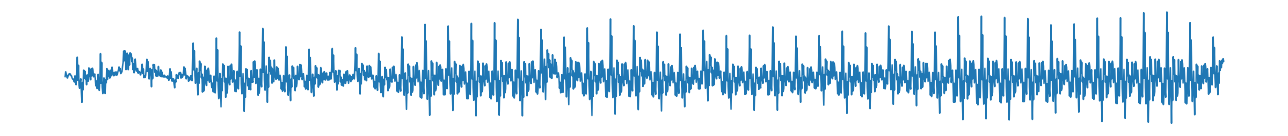

Epoch: 31 	 Discriminator Loss: [0.0017830194, 1.0] 		 Generator Loss: 11.679342269897461
Epoch: 32 	 Discriminator Loss: [0.002202681, 1.0] 		 Generator Loss: 10.176740646362305
Epoch: 33 	 Discriminator Loss: [0.0058801, 0.998] 		 Generator Loss: 13.853609085083008
Epoch: 34 	 Discriminator Loss: [0.003726503, 0.998] 		 Generator Loss: 13.277972221374512
Epoch: 35 	 Discriminator Loss: [0.003560802, 0.998] 		 Generator Loss: 13.539563179016113
Epoch: 36 	 Discriminator Loss: [0.0011518738, 1.0] 		 Generator Loss: 9.745207786560059
Epoch: 37 	 Discriminator Loss: [0.006624039, 1.0] 		 Generator Loss: 9.41690731048584
Epoch: 38 	 Discriminator Loss: [0.013182213, 0.996] 		 Generator Loss: 10.762250900268555
Epoch: 39 	 Discriminator Loss: [0.016557854, 0.996] 		 Generator Loss: 9.040358543395996
Epoch: 40 	 Discriminator Loss: [0.012390474, 0.996] 		 Generator Loss: 8.081050872802734
Epoch: 41 	 Discriminator Loss: [0.012145108, 0.996] 		 Generator Loss: 8.384115219116211
Epoch: 42 	 D

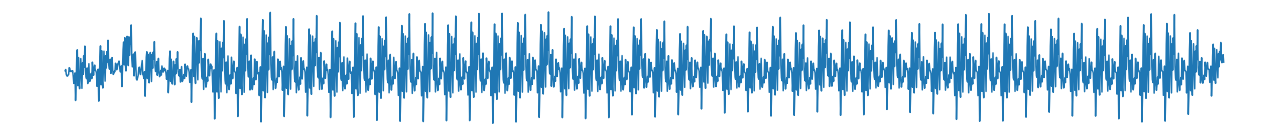

Epoch: 46 	 Discriminator Loss: [0.0022478811, 1.0] 		 Generator Loss: 11.775732040405273
Epoch: 47 	 Discriminator Loss: [0.002605865, 1.0] 		 Generator Loss: 12.329683303833008
Epoch: 48 	 Discriminator Loss: [0.0011128847, 1.0] 		 Generator Loss: 12.744314193725586
Epoch: 49 	 Discriminator Loss: [0.0013441949, 1.0] 		 Generator Loss: 11.06729793548584
Epoch: 50 	 Discriminator Loss: [0.002440755, 1.0] 		 Generator Loss: 10.4824800491333
Epoch: 51 	 Discriminator Loss: [0.0038194351, 1.0] 		 Generator Loss: 10.205520629882812
Epoch: 52 	 Discriminator Loss: [0.0045834896, 1.0] 		 Generator Loss: 9.236727714538574
Epoch: 53 	 Discriminator Loss: [0.0064998902, 0.998] 		 Generator Loss: 8.440587997436523
Epoch: 54 	 Discriminator Loss: [0.0033321697, 1.0] 		 Generator Loss: 9.662290573120117
Epoch: 55 	 Discriminator Loss: [0.0049430532, 0.998] 		 Generator Loss: 10.336034774780273
Epoch: 56 	 Discriminator Loss: [0.001930506, 1.0] 		 Generator Loss: 10.038677215576172
Epoch: 57 	 Dis

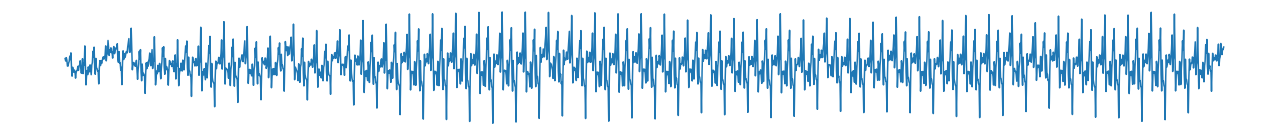

Epoch: 61 	 Discriminator Loss: [0.00022765891, 1.0] 		 Generator Loss: 13.471094131469727
Epoch: 62 	 Discriminator Loss: [0.0009275675, 1.0] 		 Generator Loss: 14.665200233459473
Epoch: 63 	 Discriminator Loss: [0.00011937735, 1.0] 		 Generator Loss: 14.61203670501709
Epoch: 64 	 Discriminator Loss: [0.0030180023, 0.998] 		 Generator Loss: 15.215667724609375
Epoch: 65 	 Discriminator Loss: [0.00084639026, 1.0] 		 Generator Loss: 16.624711990356445
Epoch: 66 	 Discriminator Loss: [0.00097363617, 1.0] 		 Generator Loss: 15.492376327514648
Epoch: 67 	 Discriminator Loss: [0.000787524, 1.0] 		 Generator Loss: 16.853151321411133
Epoch: 68 	 Discriminator Loss: [0.0007186845, 1.0] 		 Generator Loss: 17.716960906982422
Epoch: 69 	 Discriminator Loss: [0.00026904762, 1.0] 		 Generator Loss: 17.20545768737793


In [ ]:
disc_losses = []
disc_accuracies = []
gen_losses = []
def train_disc(epochs, batch_size, gen, disc):
    steps_per_epoch = round(50000//250*(1-validation_split))
    for epoch in range(epochs):
        for batch in range(steps_per_epoch):
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            real_trajs = db_train[np.arange(batch*batch_size, (batch+1)*batch_size)]
            fake_trajs = gen.predict(noise)
            trajs = np.concatenate((real_trajs, fake_trajs))
            
            disc_labels = np.zeros(2*batch_size)
            disc_labels[:batch_size] = 0.9
            disc_loss = disc.train_on_batch(trajs, disc_labels) # training del discriminatore (gli dico quali sono vere e quali no)            
            print(f'Epoch:{epoch}, batch:{batch}/{steps_per_epoch}', end="\r")
        print(f'Epoch: {epoch} \t Discriminator Loss: {disc_loss}')

def train_gan(epochs, batch_size, gen, disc, gan):
    static_noise = np.random.normal(0, 1, size=(1, noise_dim))
    steps_per_epoch = round(50000//250*(1-validation_split))
    for epoch in range(epochs):
        for batch in range(steps_per_epoch):
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            real_trajs = db_train[np.arange(batch*batch_size, (batch+1)*batch_size)]
            fake_trajs = gen.predict(noise)
            trajs = np.concatenate((real_trajs, fake_trajs))
            
            disc_labels = np.zeros(2*batch_size)
            disc_labels[:batch_size] = 1.0
            disc_loss = disc.train_on_batch(trajs, disc_labels) # training del discriminatore (gli dico quali sono vere e quali no)
    
            gen_labels = np.ones(batch_size)
            gen_loss = gan.train_on_batch(noise, gen_labels) # training del generatore (per imbrogliare il discrim.)
            
            print(f'Epoch:{epoch}, batch:{batch}/{steps_per_epoch}', end="\r")
        print(f'Epoch: {epoch} \t Discriminator Loss: {disc_loss} \t\t Generator Loss: {gen_loss}')
        disc_losses.append(disc_loss[0])
        disc_accuracies.append(disc_loss[1])
        gen_losses.append(gen_loss)
        if epoch%15==0:  plot_trajs(static_noise)

batch_size = 250
train_gan(epochs=1000, batch_size=batch_size, gen=gen, disc=disc, gan=gan)
#train_disc(epochs=3, batch_size=batch_size, gen=gen, disc=disc)

# Testing

In [129]:
noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
disc.evaluate(gen.predict(noise),np.zeros(batch_size))
disc.evaluate(db_train[np.random.randint(50000*(1-validation_split),size=batch_size)],np.ones(batch_size))

250/250 [==============================] - 0s 81us/sample - loss: 0.1083 - binary_accuracy: 1.0000


[0.10832717251777649, 1.0]

In [157]:
disc.predict(gen.predict(noise))
#disc.predict(db_train[np.random.randint(50000*(1-validation_split),size=batch_size)])

array([[2.44554877e-03],
       [3.69057059e-03],
       [3.63789201e-02],
       [2.45921016e-02],
       [1.49971247e-03],
       [2.56150961e-04],
       [1.75562948e-01],
       [2.61591971e-02],
       [5.68032265e-05],
       [1.34330094e-02],
       [1.42753124e-05],
       [1.67790055e-03],
       [1.80166960e-03],
       [6.31213188e-05],
       [1.00452721e-01],
       [8.05616379e-04],
       [5.99854052e-01],
       [1.58250332e-04],
       [4.11900282e-02],
       [2.27877498e-03],
       [2.65836716e-05],
       [9.74318981e-02],
       [2.81006098e-04],
       [3.57710421e-02],
       [6.87746108e-01],
       [1.50501728e-05],
       [1.03912562e-01],
       [2.54923701e-02],
       [1.95614100e-02],
       [7.90008903e-03],
       [2.50339508e-06],
       [5.42402267e-06],
       [5.26093841e-02],
       [3.90768051e-04],
       [4.83959913e-04],
       [1.23487860e-01],
       [2.73664892e-01],
       [1.03116035e-04],
       [4.90533710e-01],
       [6.60857558e-03],


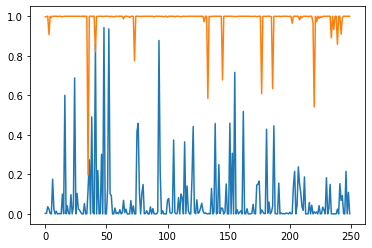

In [154]:
plt.plot(disc.predict(gen.predict(noise)))
plt.plot(disc.predict(db_train[np.random.randint(50000*(1-validation_split),size=batch_size)]))

In [ ]:
static_noise = np.random.normal(0, 1, size=(1, noise_dim))
plot_trajs(static_noise, db_train)

# Saving

In [124]:
disc.save('gan_disc_prova.h5')
gen.save('gan_gen_prova.h5')
#from tensorflow.keras.models import load_model
#disc = load_model('classificatore.h5')